# WavCeption V1: just a 1-D Inception approach 

저는 단지 제가 가지고 놀던 작은 장난감을 공유하고 싶었을 뿐인데 **놀라운 결과**를 주었습니다. 지금은 시간이 없기 때문에, 사람들이 어떻게 가지고 놀지 보려고 공유하려고 합니다. :-D. **WavCception V1** 네트워크는 일반 컨볼루션 뉴럴 네트워크에 비해 인상적인 결과를 얻을 수 있는 것으로 보이지만, 이번 경쟁에서는 전처리 및 알려지지 않은 트랙 관리에 많은 노력이 필요한 것으로 보입니다. 이것은 구글의 초기 네트워크를 기반으로 합니다. 같은 아이디어입니다. 

 저는 몇 주 전에 이러한 모듈들을 캐스케이드로 연결하여 쉽게 1D 인셉션 네트워크를 구축할 수 있도록 구현하는 모듈을 작성했습니다(아래 참조).
 
 아쉽게도 몇 가지 Kaggle의 제약으로 인해 커널 머신에서는 실행되지 않으므로 다운로드하여 자신의 머신에서 실행해 보시기 바랍니다.
 
 너무 고생하지 않고 12시간 동안 모델을 실행함으로써 리더보드에서 0.76을 달성했습니다(로컬 테스트에서는 0.84). 같은 라인의 다른 시험에서는 로컬에서 0.89를 얻었기 때문에 알려지지 않은 클립을 처리하는 방법이 크게 개선되었습니다.

## Load modules and libraries

In [4]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
import shutil # shutil 모듈은 파일과 파일 모음에 대한 여러 가지 고수준 연산을 제공합니다. 특히, 파일 복사와 삭제를 지원하는 함수가 제공됩니다
import glob # 파일 리스트 추출
import random

from tqdm import tqdm # 진행표시바
from collections import Counter # Counter('hello world') # Counter({'l': 3, 'o': 2, 'h': 1, 'e': 1, ' ': 1, 'w': 1, 'r': 1, 'd': 1})
from sklearn.preprocessing import LabelEncoder
import IPython # 인터렉티브 파이썬
from numpy.fft import rfft, irfft # 1차원 이산 푸리에변환 # 역푸리에변환
import itertools

from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy as sp
import tensorflow as tf

## Noise generation functions 

이 섹션의 코드는 다음 항목에서 차용 및 개조되었습니다.
https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py

In [5]:
def ms(x): # 제곱평균
    """Mean value of signal `x` squared.
    :param x: Dynamic quantity.
    :returns: Mean squared of `x`.
    """
    return (np.abs(x)**2.0).mean()

def normalize(y, x=None): # 일부(y)/전체(루트(제곱평균))
    """normalize power in y to a (standard normal) white noise signal.
    Optionally normalize to power in signal `x`.
    #The mean power of a Gaussian with :math:`\\mu=0` and :math:`\\sigma=1` is 1.
    """
    #return y * np.sqrt( (np.abs(x)**2.0).mean() / (np.abs(y)**2.0).mean() )
    if x is not None:
        x = ms(x)
    else:
        x = 1.0
    return y * np.sqrt( x / ms(y) ) # y/루트(제곱평균y)
    #return y * np.sqrt( ms(x) / (np.abs(y)**2.0).mean() )
    #return y * np.sqrt( 1.0 / (np.abs(y)**2.0).mean() )

def white_noise(N, state=None): # N=16000*30, state=np.random.RandomState(655321)
    state = np.random.RandomState() if state is None else state
    return state.randn(N) # 정규분포

def pink_noise(N, state=None):
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def blue_noise(N, state=None):
    """
    Blue noise. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power increases with 6 dB per octave.
    Power density increases with 3 dB per octave. 
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X)))# Filter
    y = (irfft(X*S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def brown_noise(N, state=None):
    """
    Violet noise.
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power decreases with -3 dB per octave.
    Power density decreases with 6 dB per octave. 
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = (np.arange(len(X))+1)# Filter
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def violet_noise(N, state=None):
    """
    Violet noise. Power increases with 6 dB per octave. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power increases with +9 dB per octave.
    Power density increases with +6 dB per octave. 
    
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = (np.arange(len(X)))# Filter
    y = (irfft(X*S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

In [3]:
'''
import numpy as np

N = 10
state = np.random.RandomState()
state.randn(N)

# array([-0.59026399, -0.68431962,  1.56870611, -1.10500642, -0.67393401,
#        0.10376222, -0.31171382, -0.35720405, -0.74424293,  0.12614498])

N//2+1+uneven # 6
X = state.randn(N//2+1+uneven) # array([-0.17811637,  0.56738609,  0.1139559 , -0.1609064 , -0.0583465 , 0.09898859])
state = np.random.RandomState()
uneven = N%2 # 나머지

X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven) 
#array([-0.67854019+0.33696715j, -0.53639523-1.33228336j,
#       -0.16807449-1.02284005j,  0.57717245+0.56470304j,
#       -0.563283  +1.19573055j, -1.07630368+0.5818659j ])

S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero 
# array([1.        , 1.41421356, 1.73205081, 2.        , 2.23606798,       2.44948974])

X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero
y = (irfft(X/S)).real

if uneven:
    y = y[:-1]
normalize(y)

#array([-1.13220548,  0.52472321,  1.24908875,  0.27902739, -0.36896684,
#       -0.32109447, -1.36113839, -1.96029794, -0.84810501, -0.38821552])
'''

'\nimport numpy as np\n\nN = 10\nstate = np.random.RandomState()\nstate.randn(N)\n\n# array([-0.59026399, -0.68431962,  1.56870611, -1.10500642, -0.67393401,\n#        0.10376222, -0.31171382, -0.35720405, -0.74424293,  0.12614498])\n\nN//2+1+uneven # 6\nX = state.randn(N//2+1+uneven) # array([-0.17811637,  0.56738609,  0.1139559 , -0.1609064 , -0.0583465 , 0.09898859])\nstate = np.random.RandomState()\nuneven = N%2 # 나머지\nX = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven) \n#array([-0.67854019+0.33696715j, -0.53639523-1.33228336j,\n#       -0.16807449-1.02284005j,  0.57717245+0.56470304j,\n#       -0.563283  +1.19573055j, -1.07630368+0.5818659j ])\nS = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero \n# array([1.        , 1.41421356, 1.73205081, 2.        , 2.23606798,       2.44948974])\n\nX = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)\nS = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero\ny = (irfft(X/S)).real\n\nif uneven:\n    y

## Tensorflow utilities

텐서플로우 공통 작업을 모듈화하기 위한 유틸리티입니다.


In [6]:
# Tf Utils
def get_tensorflow_configuration(device="0", memory_fraction=1): # memory_fraction=1 : 100% 사용 # configuration : 구성
    """
    사용할 GPU 및 프로세스에서 사용할 수 있는 메모리 양을 선택하는 기능입니다.
    1. device: 사용할 장치를 지정합니다(str)
    2. memory_fraction: 할당해야 하는 메모리의 비율입니다(float)
    3. return: 세션에 전달할 구성입니다(tf 개체)
    """
    device = str(device)
    config = tf.compat.v1.ConfigProto() 
    config.allow_soft_placement = True # 선택한 장치가 없으면 다른 장치로 대체
    config.gpu_options.per_process_gpu_memory_fraction = memory_fraction
    config.gpu_options.visible_device_list = device
    return(config)


def start_tensorflow_session(device="0", memory_fraction=1):
    """
    사용할 GPU 장치를 처리하는 텐서플로우 세션을 시작합니다.
    이 부분은 미리 인식될 메모리의 비율입니다.
    
    1. return: configured tf.Session
    """
    return(tf.compat.v1.Session(config=get_tensorflow_configuration(device=device, memory_fraction=memory_fraction)))


def get_summary_writer(session, logs_path, project_id, version_id): # 경로를 새로 만들어서 결과물(그래프)을 저장한다.
    # sw = get_summary_writer(tf.compat.v1.Session(device='1'), "~/.logs_tensorboard/", "wavception", "V1") 
    """
    For Tensorboard reporting
    1. session: opened tensorflow session (tf.Session)
    2. logs_path: 텐서보드가 로그를 찾는 경로입니다. (str)
    3. project_id: 보고용 프로젝트 이름입니다. (str)
    4. version_id: 보고용 버전 이름입니다.(str)
    5. return summary_writer: the tensorboard writer
    """
    path = os.path.join(logs_path,"{}_{}".format(project_id, version_id)) # '~/.logs_tensorboard/wavception_V1'
    
    if os.path.exists(path):
        shutil.rmtree(path) # 전체 디렉터리 트리를 삭제합니다
    
    summary_writer = tf.summary.FileWriter(path, graph_def=session.graph_def) #  path에 그래프(graph_def) 생성
    
    return(summary_writer)

In [7]:
#sw = get_summary_writer(sess, "~/.logs_tensorboard/", "wavception", "V1")
path = os.path.join("~/.logs_tensorboard/","{}_{}".format("wavception", "V1")) # 
path

'~/.logs_tensorboard/wavception_V1'

## Paths management module

경로를 처리할 모듈입니다.


In [5]:
'''
def abc(x):
    def ab(*arg, **kwargs)
        return x(*arg, **kwargs)
    return ab
    
'''

'\ndef abc(x):\n    def ab(*arg, **kwargs)\n        return x(*arg, **kwargs)\n    return ab\n    \n'

In [8]:
# Common paths
def _norm_path(path):
    """
    경로 검색 함수의 출력을 정규화하는 데 사용하기 위한 데코레이터 함수입니다.
    슬래시/백슬래시 windows 케이스를 수정하는 데 유용합니다.
    """
    def normalize_path(*args, **kwargs):
        return os.path.normpath(path(*args, **kwargs))
    
    return normalize_path


def _assure_path_exists(path): # assure : 확신
    """
    경로 검색 함수의 출력 여부를 확인하기 위한 데코레이터 함수입니다.
    fixing the slash/backslash windows cases.
    """
    def assure_exists(*args, **kwargs):
        p=path(*args, **kwargs)
        
        assert os.path.exists(p), "the following path does not exist: '{}'".format(p)
        return p
    
    return assure_exists


def _is_output_path(path):
    """
    출력 경로 검색 함수의 출력에 적용되는 함수를 그룹화하기 위한 데코레이터 함수입니다.
    """
    @_norm_path
    @_assure_path_exists
    def check_existence_or_create_it(*args, **kwargs):
        if not os.path.exists(path(*args, **kwargs)):
            "Path does not exist... creating it: {}".format(path(*args, **kwargs))
            os.makedirs(path(*args, **kwargs))
        return path(*args, **kwargs)
    return check_existence_or_create_it


def _is_input_path(path):
    """
    입력 경로 검색 함수의 출력에 적용되는 함수를 그룹화하기 위한 데코레이터 함수입니다.
    """
    @_norm_path
    @_assure_path_exists
    def check_existence(*args, **kwargs):
        return path(*args, **kwargs)
    return check_existence

@_is_input_path
def get_train_path():
    path = "./input/train/train"
    return path

@_is_input_path
def get_test_path():
    path = "./input/test/test"
    return path

@_is_input_path
def get_train_audio_path():
    path = os.path.join(get_train_path(), "audio")
    return path

@_is_input_path
def get_scoring_audio_path():
    path = os.path.join(get_test_path(), "audio")
    return path

@_is_output_path
def get_submissions_path():
    path = "../working/output"
    return path

@_is_output_path
def get_silence_path():
    path = "../working/silence"
    return path

## Utilities

일반적인 범용 유틸리티입니다.


In [9]:
# Utilities
flatten = lambda l: [item for sublist in l for item in sublist]

def batching(iterable, n=1): # iterable=filepaths, n =1000
    l = len(iterable)# 72000
    for ndx in range(0, l, n): # ndx = 1000, 2000, ..., 72000
        yield iterable[ndx:min(ndx + n, l)] # filepaths[1000:2000], filepaths[2000:3000], ..., filepaths[71000:72000]

## Data Tools

Data handling tools

In [14]:
filepath = './input/train/train/audio/_background_noise_/exercise_bike.wav'
sample_rate, x = wavfile.read(filepath)
target = os.path.split(os.path.split(filepath)[0])[1] # '_background_noise_'

for filepaths in batching(filepath, 1000):
    wavs, targets = zip(*list(map(read_wav, filepaths))) # map(+1해주는 함수/조건, 반복)
targets

C:\Users\HOME\AppData\Local\Temp/ipykernel_8536/2859869491.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, x = wavfile.read(filepath)


PermissionError: [Errno 13] Permission denied: '.'

In [18]:
filepath = './input/train/train/audio/_background_noise_/exercise_bike.wav'
read_wav(filepath, pad=False)

C:\Users\HOME\AppData\Local\Temp/ipykernel_8536/3694018068.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, x = wavfile.read(filepath)


(array([ 0.        ,  0.        ,  0.        , ..., -0.02764893,
        -0.01760864,  0.00912476]),
 '_background_noise_')

In [38]:
for filepaths in batching(filepath, n=10):
    wavs, targets = zip(*list((read_wav(filepaths, pad=False)))) # map(+1해주는 함수/조건, 반복)
targets

FileNotFoundError: [Errno 2] No such file or directory: './input/tr'

In [10]:
# Data tools
def read_wav(filepath, pad=True):
    """
    wav 파일의 파일 경로를 지정하면 이 함수는 파일을 읽고 정규화하고 패드를 채웁니다.
    16k개의 샘플을 가지고 있는지 확인합니다.
    1. filepath: wav 파일의 기존 파일 경로입니다. (str)
    2. pad: 패딩이 필요합니까? (bool)
    3. returns: 표본과 목표 변수 (tuple of (np.array, str))
    """
    sample_rate, x = wavfile.read(filepath)
    target = os.path.split(os.path.split(filepath)[0])[1] # '_background_noise_'
    assert sample_rate==16000
    if pad:
        return np.pad(x, (0, 16000-len(x)), mode="constant")/32768, target
    else:
        return x/32768, target

def get_batcher(list_of_paths, batch_size, label_encoder=None, scoring=False): 
    # get_batcher(testing_list, 64, le_classes)
    # list_of_paths = './input/train/train/audio/**/*.wav', batchsize=1000/0, label_encoder = LabelEncoder().fit(cardinal_classes)
    """ 
    배치 목록이 지정된 배치 생성기를 작성합니다.
    1. list_of_paths: 형식 요소가 있는 튜플 리스트입니다. (filepath, target) (list)
    2. batch_size: size of the batch (int)
    3. label_encoder: fitted LabelEncoder (sklearn.LabelEncoder|optional)
    4. scoring: 대상을 고려해야 합니까? (bool)
    5. returns: batch generator
    """
    for filepaths in batching(list_of_paths, batch_size):
        wavs, targets = zip(*list(map(read_wav, filepaths))) # map(+1해주는 함수/조건, 반복)
        if scoring:
            yield np.expand_dims(np.row_stack(wavs), 2), filepaths # np.row_stack() = np.vstack()
        else:
            if label_encoder is None:
                yield np.expand_dims(np.row_stack(wavs), 2), np.row_stack(targets)
            else:
                yield np.expand_dims(np.row_stack(wavs), 2), np.expand_dims(label_encoder.transform(np.squeeze(targets)), 1)

## Architecture building blocks

Inception-1D(일명 wavception)는 이 문제를 해결하기 위해 몇 주 전에 설계한 모듈입니다. 그것은 규칙적인 컨볼루션 뉴럴 네트의 성능을 상당히 향상시킵니다.

In [9]:
'''
tf.compat.v1.disable_eager_execution()

holder1 = tf.compat.v1.placeholder(dtype=tf.float32)
holder2 = tf.compat.v1.placeholder(dtype=tf.float32)
holder3 = tf.compat.v1.placeholder(dtype=tf.float32)
 
v1 = 5
v2 = 10
v3 = 3
 
# 함수    
ret_val = holder1 * holder2 + holder3 # <tf.Tensor 'add:0' shape=<unknown> dtype=float32>

# 값 할당
feed_dict = {holder1: v1, holder2: v2, holder3: v3}

# 값계산을 위한 세션 사용
def get_tensorflow_configuration(device="0", memory_fraction=1): # memory_fraction=1 : 100% 사용 # configuration : 구성
    device = str(device)
    config = tf.compat.v1.ConfigProto() 
    config.allow_soft_placement = True # 선택한 장치가 없으면 다른 장치로 대체
    config.gpu_options.per_process_gpu_memory_fraction = memory_fraction
    config.gpu_options.visible_device_list = device
    return(config)


def start_tensorflow_session(device="0", memory_fraction=1):
    return(tf.compat.v1.Session(config=get_tensorflow_configuration(device=device, memory_fraction=memory_fraction)))

sess = start_tensorflow_session(device="1")

result = sess.run(ret_val, feed_dict=feed_dict)
 
print(result)
'''

'\ntf.compat.v1.disable_eager_execution()\n\nholder1 = tf.compat.v1.placeholder(dtype=tf.float32)\nholder2 = tf.compat.v1.placeholder(dtype=tf.float32)\nholder3 = tf.compat.v1.placeholder(dtype=tf.float32)\n \nv1 = 5\nv2 = 10\nv3 = 3\n \n# 함수    \nret_val = holder1 * holder2 + holder3 # <tf.Tensor \'add:0\' shape=<unknown> dtype=float32>\n\n# 값 할당\nfeed_dict = {holder1: v1, holder2: v2, holder3: v3}\n\n# 값계산을 위한 세션 사용\ndef get_tensorflow_configuration(device="0", memory_fraction=1): # memory_fraction=1 : 100% 사용 # configuration : 구성\n    device = str(device)\n    config = tf.compat.v1.ConfigProto() \n    config.allow_soft_placement = True # 선택한 장치가 없으면 다른 장치로 대체\n    config.gpu_options.per_process_gpu_memory_fraction = memory_fraction\n    config.gpu_options.visible_device_list = device\n    return(config)\n\n\ndef start_tensorflow_session(device="0", memory_fraction=1):\n    return(tf.compat.v1.Session(config=get_tensorflow_configuration(device=device, memory_fraction=memory_fraction)

In [11]:
class BatchNorm(object):
    def __init__(self, epsilon=1e-5, momentum=0.999, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x,
                                            decay=self.momentum,
                                            updates_collections=None,
                                            epsilon=self.epsilon,
                                            scale=True,
                                            is_training=train,
                                            scope=self.name)
    
def inception_1d(x, is_train, depth, norm_function, activ_function, name):  # depth=1,2,3,4
    """
    inception_1d(x=self.placeholders.wav_in=batch_x=get_batcher=train_list=,
                            is_train=self.placeholders.is_train=bool, 
                             norm_function=BatchNorm=tf.contrib.layers.batch_norm(x), 
                             activ_function=tf.nn.relu, depth=1,
                             name="Inception_1_1")
                             
    Inception 1D 모듈 구현입니다.
    1. x: 현재 모듈에 입력합니다. (4D tensor with channels-last)
    2. is_train: BatchNormalization 동작을 제어하기 위한 부울 자리 표시자가 되려고 합니다. (0D tensor)
    3. depth: 네트워크의 깊이를 선형적으로 제어합니다.(int)
    4. norm_function: 정규화 클래스입니다. (same format as the BatchNorm class above)
    5. activ_function: 활성화함수 (e.g. tf.nn.relu) 
    6. name: 변수 범위의 이름입니다. (str)
    """
    with tf.variable_scope(name):
        x_norm = norm_function(name="norm_input")(x, train=is_train) # BatchNorm(name='norm_input')(x, train=s)

        # Branch 1: 64 x conv 1x1 
        branch_conv_1_1 = tf.layers.conv1d(inputs=x_norm, filters=16*depth, kernel_size=1,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_1_1")
        branch_conv_1_1 = norm_function(name="norm_conv_1_1")(branch_conv_1_1, train=is_train) # BatchNorm
        branch_conv_1_1 = activ_function(branch_conv_1_1, "activation_1_1")  # tf.nn.relu

        # Branch 2: 128 x conv 3x3 
        branch_conv_3_3 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_3_3_1")
        branch_conv_3_3 = norm_function(name="norm_conv_3_3_1")(branch_conv_3_3, train=is_train)
        branch_conv_3_3 = activ_function(branch_conv_3_3, "activation_3_3_1")

        branch_conv_3_3 = tf.layers.conv1d(inputs=branch_conv_3_3, filters=32*depth, kernel_size=3, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_3_3_2")
        branch_conv_3_3 = norm_function(name="norm_conv_3_3_2")(branch_conv_3_3, train=is_train)
        branch_conv_3_3 = activ_function(branch_conv_3_3, "activation_3_3_2")

        # Branch 3: 128 x conv 5x5 
        branch_conv_5_5 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_5_5_1")
        branch_conv_5_5 = norm_function(name="norm_conv_5_5_1")(branch_conv_5_5, train=is_train)
        branch_conv_5_5 = activ_function(branch_conv_5_5, "activation_5_5_1")

        branch_conv_5_5 = tf.layers.conv1d(inputs=branch_conv_5_5, filters=32*depth, kernel_size=5, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_5_5_2")
        branch_conv_5_5 = norm_function(name="norm_conv_5_5_2")(branch_conv_5_5, train=is_train)
        branch_conv_5_5 = activ_function(branch_conv_5_5, "activation_5_5_2")

        # Branch 4: 128 x conv 7x7
        branch_conv_7_7 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_7_7_1")
        branch_conv_7_7 = norm_function(name="norm_conv_7_7_1")(branch_conv_7_7, train=is_train)
        branch_conv_7_7 = activ_function(branch_conv_7_7, "activation_7_7_1")

        branch_conv_7_7 = tf.layers.conv1d(inputs=branch_conv_7_7, filters=32*depth, kernel_size=5, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_7_7_2")
        branch_conv_7_7 = norm_function(name="norm_conv_7_7_2")(branch_conv_7_7, train=is_train)
        branch_conv_7_7 = activ_function(branch_conv_7_7, "activation_7_7_2")

        # Branch 5: 16 x (max_pool 3x3 + conv 1x1)
        branch_maxpool_3_3 = tf.layers.max_pooling1d(inputs=x_norm, pool_size=3, strides=1, padding="same", name="maxpool_3")
        branch_maxpool_3_3 = norm_function(name="norm_maxpool_3_3")(branch_maxpool_3_3, train=is_train)
        branch_maxpool_3_3 = tf.layers.conv1d(inputs=branch_maxpool_3_3, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_maxpool_3")

        # Branch 6: 16 x (max_pool 5x5 + conv 1x1)
        branch_maxpool_5_5 = tf.layers.max_pooling1d(inputs=x_norm, pool_size=5, strides=1, padding="same", name="maxpool_5")
        branch_maxpool_5_5 = norm_function(name="norm_maxpool_5_5")(branch_maxpool_5_5, train=is_train)
        branch_maxpool_5_5 = tf.layers.conv1d(inputs=branch_maxpool_5_5, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_maxpool_5")

        # Branch 7: 16 x (avg_pool 3x3 + conv 1x1)
        branch_avgpool_3_3 = tf.layers.average_pooling1d(inputs=x_norm, pool_size=3, strides=1, padding="same", name="avgpool_3")
        branch_avgpool_3_3 = norm_function(name="norm_avgpool_3_3")(branch_avgpool_3_3, train=is_train)
        branch_avgpool_3_3 = tf.layers.conv1d(inputs=branch_avgpool_3_3, filters=16, kernel_size=1,
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_avgpool_3")

        # Branch 8: 16 x (avg_pool 5x5 + conv 1x1)
        branch_avgpool_5_5 = tf.layers.average_pooling1d(inputs=x_norm, pool_size=5, strides=1, padding="same", name="avgpool_5")
        branch_avgpool_5_5 = norm_function(name="norm_avgpool_5_5")(branch_avgpool_5_5, train=is_train)
        branch_avgpool_5_5 = tf.layers.conv1d(inputs=branch_avgpool_5_5, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_avgpool_5")

        # Concatenate
        output = tf.concat([branch_conv_1_1, branch_conv_3_3, branch_conv_5_5, branch_conv_7_7, branch_maxpool_3_3, 
                           branch_maxpool_5_5, branch_avgpool_3_3, branch_avgpool_5_5], axis=-1)
        return output


## Load and prepare Data

In [9]:
filepaths_noise = glob.glob(os.path.join(get_train_audio_path(), "_background_noise_", "*.wav")) 
filepaths_noise

['input\\train\\train\\audio\\_background_noise_\\doing_the_dishes.wav',
 'input\\train\\train\\audio\\_background_noise_\\dude_miaowing.wav',
 'input\\train\\train\\audio\\_background_noise_\\exercise_bike.wav',
 'input\\train\\train\\audio\\_background_noise_\\pink_noise.wav',
 'input\\train\\train\\audio\\_background_noise_\\running_tap.wav',
 'input\\train\\train\\audio\\_background_noise_\\white_noise.wav']

In [49]:
list(map(lambda i: i, [1, 2]))

[1, 2]

In [51]:
noise = np.concatenate(list(map(lambda x: read_wav(x, False)[0], filepaths_noise))) # x= filepaths_noise
noise.shape

C:\Users\HOME\AppData\Local\Temp/ipykernel_8536/3694018068.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, x = wavfile.read(filepath)


(6390371,)

In [12]:
# 합성 및 제공된 소음 추가입니다.
filepaths_noise = glob.glob(os.path.join(get_train_audio_path(), "_background_noise_", "*.wav")) 
# filepaths_noise = './input/train/train/audio/_background_noise_/*.wav'

# _background_noise_에 있는 노이즈를 모두 합친다.
noise = np.concatenate(list(map(lambda x: read_wav(x, False)[0], filepaths_noise))) # (6390371,), x= filepaths_noise
# [x1.wav/32768, x2.wav/32768, x3.wav/32768, ...]
# 노이즈의 내림차순으로 한번 합친다.
noise = np.concatenate([noise, noise[::-1]]) # [x1/32768, x2/32768, x3/32768, ... , x3/32768, x2/32768, x1/32768] - > (12780742,)

# 실제 있는 blue/pink.. noise를 합치고 분수화 한다. + 작업하나 더 한 후 위의 노이즈와 합친다.
synthetic_noise = np.concatenate([white_noise(N=16000*30, state=np.random.RandomState(655321)), 
                                  blue_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  pink_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  brown_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  violet_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  np.zeros(16000*60)]) # (3360000,)

synthetic_noise /= np.max(np.abs(synthetic_noise)) # [w/k, b/k, p/k, b/k, v/k, z/k ]
synthetic_noise = np.concatenate([synthetic_noise, (synthetic_noise+synthetic_noise[::-1])/2])  # [w/k, b/k, p/k, b/k, v/k, z/k, (w/k+z/k)/2, ... ]
all_noise = np.concatenate([noise, synthetic_noise]) # [x1/32768, x2/32768, x3/32768, ... , x3/32768, x2/32768, x1/32768, w/k, b/k, p/k, b/k, v/k, z/k, (w/k+z/k)/2, ... ]
all_noise.shape # (19500742,)
all_noise

C:\Users\HOME\AppData\Local\Temp/ipykernel_8276/3277725824.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, x = wavfile.read(filepath)


array([ 0.        ,  0.        ,  0.        , ...,  0.02363595,
       -0.16235002, -0.09919803])

In [42]:
synthetic_noise = np.concatenate([white_noise(N=16000*30, state=np.random.RandomState(655321)), 
                                  blue_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  pink_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  brown_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  violet_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  np.zeros(16000*60)])
synthetic_noise.shape

(3360000,)

In [12]:
noise.shape

(12780742,)

In [13]:
'''
a= [1,2,3,4]
b = a[::-1]
c = np.concatenate([a, b])
c # array([1, 2, 3, 4, 4, 3, 2, 1])
'''

'\na= [1,2,3,4]\nb = a[::-1]\nc = np.concatenate([a, b])\nc # array([1, 2, 3, 4, 4, 3, 2, 1])\n'

In [13]:
np.random.seed(655321)
random.seed(655321)

path = get_silence_path() # "../working/silence" 출력경로

if not os.path.exists(path):
    os.makedirs(path) # 읽기 전용 파일 시스템으로 인해 kaggle 커널에서 실패합니다.

# 기존 음성파일에 더해줄 노이즈를 추출한다.(절반은 noise, 절반은 synthetic_noise로)     
for noise_clip_no in tqdm(range(8000)): # 진행표시바
    if noise_clip_no<=4000:
        idx = np.random.randint(0, len(noise)-16000) # (0, 12,780,742-16,000) 중 하나 추출
        clip = noise[idx:(idx+16000)]
    else:
        idx = np.random.randint(0, len(synthetic_noise)-16000)
        clip = synthetic_noise[idx:(idx+16000)]
    
    # wavfile.write(파일명, rate, 데이터=분수화)
    wavfile.write(os.path.join(path, "{0:04d}.wav".format(noise_clip_no)), 16000, 
                               ((32767*clip/np.max(np.abs(clip))).astype(np.int16))) 
    # wavfile.write(filename, rate, data)

 49%|█████████████████████████████████████▉                                       | 3940/8000 [00:04<00:04, 866.10it/s]C:\Users\HOME\AppData\Local\Temp/ipykernel_8276/3625355955.py:20: RuntimeWarning: invalid value encountered in true_divide
  ((32767*clip/np.max(np.abs(clip))).astype(np.int16)))
100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1069.61it/s]


In [15]:
# 음성파일과 노이즈 합치기

filepaths = glob.glob(os.path.join(get_train_audio_path(), "**/*.wav"), recursive=True) # filepaths = './input/train/train/audio/**/*.wav'
# 파라미터 recursive=True 로 설정하고 ** 로 작성하면 하위 폴더에도 접근할 수 있습니다
filepaths += glob.glob(os.path.join(get_silence_path(), "**/*.wav"), recursive=True) # "../working/silence"
filepaths = list(filter(lambda fp: "_background_noise_" not in fp, filepaths)) # filter(조건 함수, 순회 가능한 데이터) : fp에 filepaths 대입
filepaths[-1]

'..\\working\\silence\\7999.wav'

In [16]:
# validation 리스트
validation_list = open(os.path.join(get_train_path(), "validation_list.txt")).readlines() # './input/train/train/validation_list.txt'
validation = []
for val in validation_list:
    validation.append(val.replace('/', '\\'))
    
# test 리스트
test_list = open(os.path.join(get_train_path(), "testing_list.txt")).readlines() # './input/train/train/testing_list.txt'
test = []
for ts in test_list:
    test.append(ts.replace('/', '\\'))

validation_list = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip()), validation)) # './input/train/train/audio/vl1.wav, ...'
testing_list = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip()), test)) # './input/train/train/audio/t1.wav, ...'

# train에서 validation과 test의 리스트를 제거
training_list = np.setdiff1d(filepaths, validation_list+testing_list).tolist() # np.setdiff1d(차집합)
len(training_list)

59088

In [17]:
'''
validation_list124 = open(os.path.join(get_train_path(), "validation_list.txt")).readlines() # './input/train/train/validation_list.txt'
validation_list12 = []
for i in validation_list124:
    validation_list12.append(i.replace('/', '\\'))

validation_list12

validation_list13 = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip()), validation_list12)) # './input/train/train/audio/vl1.wav, ...'
validation_list13'''

'\nvalidation_list124 = open(os.path.join(get_train_path(), "validation_list.txt")).readlines() # \'./input/train/train/validation_list.txt\'\nvalidation_list12 = []\nfor i in validation_list124:\n    validation_list12.append(i.replace(\'/\', \'\\\'))\n\nvalidation_list12\n\nvalidation_list13 = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip()), validation_list12)) # \'./input/train/train/audio/vl1.wav, ...\'\nvalidation_list13'

In [18]:
'''
filepaths = glob.glob(os.path.join(get_train_audio_path(), "**/*.wav"), recursive=True) # filepaths = './input/train/train/audio/**/*.wav'
# 파라미터 recursive=True 로 설정하고 ** 로 작성하면 하위 폴더에도 접근할 수 있습니다
filepaths += glob.glob(os.path.join(get_silence_path(), "**/*.wav"), recursive=True) # "../working/silence"
filepaths = list(filter(lambda fp: "_background_noise_" not in fp, filepaths)) # '_background_noise_'를 제외# filter(조건 함수, 순회 가능한 데이터) : fp에 filepaths 대입
filepaths
''' 

'\nfilepaths = glob.glob(os.path.join(get_train_audio_path(), "**/*.wav"), recursive=True) # filepaths = \'./input/train/train/audio/**/*.wav\'\n# 파라미터 recursive=True 로 설정하고 ** 로 작성하면 하위 폴더에도 접근할 수 있습니다\nfilepaths += glob.glob(os.path.join(get_silence_path(), "**/*.wav"), recursive=True) # "../working/silence"\nfilepaths = list(filter(lambda fp: "_background_noise_" not in fp, filepaths)) # \'_background_noise_\'를 제외# filter(조건 함수, 순회 가능한 데이터) : fp에 filepaths 대입\nfilepaths\n'

In [19]:
'''
a = ['c']
b = ['d']
a+b # ['c', 'd']
'''

"\na = ['c']\nb = ['d']\na+b # ['c', 'd']\n"

In [20]:
random.seed(655321)
random.shuffle(filepaths)
random.shuffle(validation_list)
random.shuffle(testing_list)
random.shuffle(training_list)

In [21]:
len(filepaths) # 72721
len(validation_list) # 6798
len(testing_list) # 6835
len(training_list) # 59088

59088

In [22]:
# 빠른 단위 테스트입니다.
# 파일 수와 파일 일관성을 테스트합니다.
assert all(map(lambda fp: os.path.splitext(fp)[1]==".wav", filepaths))
assert len(filepaths)==64727 - 6 + 8000
assert len(training_list) == len(filepaths) - len(validation_list) - len(testing_list) 
assert len(validation_list) == 6798
assert len(testing_list) == 6835

# 파일 존재 여부를 테스트합니다.
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), validation_list))
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), testing_list))
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), training_list))
assert set(validation_list + testing_list + training_list) == set(filepaths)

# 집합 간에 겹치지 않도록 테스트합니다.
assert len(np.intersect1d(validation_list, testing_list))==0 # np.intersect1d(교집합)
assert len(np.intersect1d(training_list, testing_list))==0
assert len(np.intersect1d(training_list, validation_list))==0

In [23]:
# Classes processing
cardinal_classes = list(set(map(lambda fp:os.path.split(os.path.split(fp)[0])[1], filepaths))) 
# ['stop', 'off', 'up', 'zero', 'bed', ... 'silence','three']
le_classes = LabelEncoder().fit(cardinal_classes)
Counter(map(lambda fp:os.path.split(os.path.split(fp)[0])[1], filepaths))

Counter({'no': 2375,
         'yes': 2377,
         'stop': 2380,
         'nine': 2364,
         'left': 2353,
         'dog': 1746,
         'wow': 1745,
         'up': 2375,
         'one': 2370,
         'six': 2369,
         'zero': 2376,
         'two': 2373,
         'sheila': 1734,
         'tree': 1733,
         'silence': 8000,
         'four': 2372,
         'marvin': 1746,
         'bed': 1713,
         'right': 2367,
         'seven': 2377,
         'cat': 1733,
         'eight': 2352,
         'five': 2357,
         'on': 2367,
         'happy': 1742,
         'off': 2357,
         'three': 2356,
         'go': 2372,
         'down': 2359,
         'bird': 1731,
         'house': 1750})

In [24]:
len(cardinal_classes)

31

In [25]:
# Quick Unit-Tests
# Test data preparation
_gen_test = get_batcher(filepaths, 1000) # filepaths = './input/train/train/audio/**/*.wav' # wav, target
batch_a_wav, batch_a_target = next(_gen_test) # ex) [[값], [값],..], [['bed'], ['no']]
batch_b_wav, batch_b_target = next(_gen_test) 
_gen_test_le = get_batcher(filepaths, 1000, label_encoder=le_classes)
batch_le_wav, batch_le_target = next(_gen_test_le) # ex) [[4], [23], [31] 

# 배치 행렬 모양 일관성을 검정합니다.
assert batch_a_wav.shape == (1000, 16000, 1)
assert batch_le_wav.shape == (1000, 16000, 1)
assert batch_a_wav.shape == batch_b_wav.shape == batch_le_wav.shape

# 배치 재현성을 테스트합니다.
assert np.sum(np.abs(batch_a_wav-batch_b_wav)) != 0
assert len(batch_a_target) == len(batch_b_target) == len(batch_le_target)
assert any(batch_a_target != batch_b_target)

# 테스트 클래스 레이블 인코더입니다.
assert all(batch_le_target == np.expand_dims(le_classes.transform(np.squeeze(batch_a_target)),1))

In [26]:
batch_le_wav

array([[[ 0.00000000e+00],
        [-4.57763672e-04],
        [-4.57763672e-04],
        ...,
        [-6.40869141e-04],
        [-5.79833984e-04],
        [-5.79833984e-04]],

       [[ 0.00000000e+00],
        [ 1.22070312e-04],
        [-3.05175781e-05],
        ...,
        [-2.74658203e-04],
        [-3.66210938e-04],
        [-1.52587891e-04]],

       [[ 6.10351562e-05],
        [-3.05175781e-05],
        [ 2.13623047e-04],
        ...,
        [-3.35693359e-04],
        [-3.96728516e-04],
        [-3.05175781e-04]],

       ...,

       [[-1.70898438e-03],
        [-2.74658203e-03],
        [-2.41088867e-03],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[-1.43432617e-03],
        [-1.92260742e-02],
        [-2.43530273e-02],
        ...,
        [ 1.60522461e-02],
        [ 1.59606934e-02],
        [ 1.48620605e-02]],

       [[-1.19018555e-03],
        [-1.98364258e-03],
        [-2.04467773e-03],
        ...,
        

In [27]:
'''
aa = iter([1,2,3])
xx= next(aa) # 1
yy= next(aa) # 2
'''

'\naa = iter([1,2,3])\nxx= next(aa) # 1\nyy= next(aa) # 2\n'

In [28]:
'''
wavs, targets = zip(*list(map(read_wav, 'input\\train\\train\\audio\\bed\\3903b558_nohash_0.wav',)))
wavs 
# (array([-0.00073242, -0.00198364, -0.00137329, ...,  0.00164795,
#          0.00189209,  0.00216675]),)
targets
# ('bed',)
np.expand_dims(np.row_stack(wavs), 2)
# array([[[-0.00073242],
#        [-0.00198364],
#        [-0.00137329],
#        ...,
#        [ 0.00164795],
#        [ 0.00189209],
#        [ 0.00216675]]])

np.row_stack(targets)
# array([['bed']], dtype='<U3')
'''

"\nwavs, targets = zip(*list(map(read_wav, 'input\\train\\train\\audio\\bed\\3903b558_nohash_0.wav',)))\nwavs \n# (array([-0.00073242, -0.00198364, -0.00137329, ...,  0.00164795,\n#          0.00189209,  0.00216675]),)\ntargets\n# ('bed',)\nnp.expand_dims(np.row_stack(wavs), 2)\n# array([[[-0.00073242],\n#        [-0.00198364],\n#        [-0.00137329],\n#        ...,\n#        [ 0.00164795],\n#        [ 0.00189209],\n#        [ 0.00216675]]])\n\nnp.row_stack(targets)\n# array([['bed']], dtype='<U3')\n"

## Architecture design

Here it comes, WavCeption design

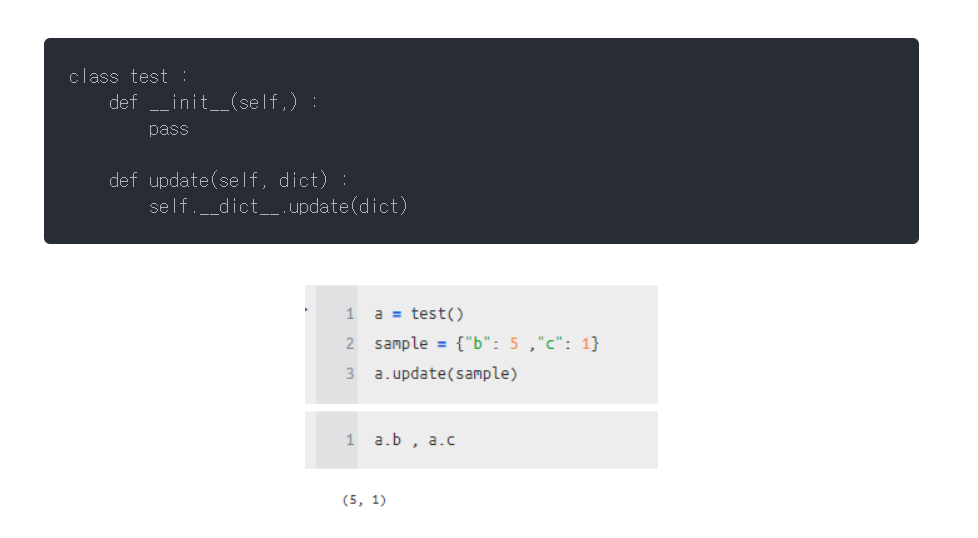

In [1]:
class Student:
    name = ''

    korean = 0

    english = 0

    math = 0

    def __init__(self, name, kor, eng, math):

        self.name = name

        self.korean = kor

        self.english = eng

        self.math = math



In [3]:
a = Student('홍길동', 80, 85, 75)
a

In [ ]:
# 동적 할당
class NameSpacer:
    def __init__(self, **kwargs): # {"wav_in": wav_in, "target": target, "is_train": is_train, "acc_dev": acc_dev, "loss_dev": loss_dev}
        self.__dict__.update(kwargs)

# 모델
class Architecture: 
    # net = Architecture(self, class_cardinality=len(cardinal_classes), name="wavception")
    # cardinal_classes = list(set(map(lambda fp:os.path.split(os.path.split(fp)[0])[1], filepaths))) # ['no','bed',...]
    # len(cardinal_classes) = 31
    def __init__(self, class_cardinality, seq_len=16000, name="architecture"):
        self.seq_len = seq_len # 16,000
        self.class_cardinality = class_cardinality # 31
        self.name = name # wavception
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.define_computation_graph()
        
        # 별칭
        self.ph = self.placeholders
        self.op = self.optimizers
        self.summ = self.summaries

    def define_computation_graph(self):
        # Reset graph
        tf.reset_default_graph()
        self.placeholders = NameSpacer(**self.define_placeholders()) # self.__dict__.update(define_placeholders()) = NameSpacer().Placeholders/wav_in/.target/...
        self.core_model = NameSpacer(**self.define_core_model()) # NameSpacer().Core_Model/output
        self.losses = NameSpacer(**self.define_losses()) # NameSpacer().softmax_ce
        self.optimizers = NameSpacer(**self.define_optimizers()) # NameSpacer().op
        self.summaries = NameSpacer(**self.define_summaries()) # NameSpacer().acc/.loss/.train_performance_scalar/.dev_performance_scalar

    def define_placeholders(self):
        with tf.variable_scope("Placeholders"):
            wav_in = tf.placeholder(dtype=tf.float32, shape=(None, self.seq_len, 1), name="wav_in")
            is_train = tf.placeholder(dtype=tf.bool, shape=None, name="is_train")
            target = tf.placeholder(dtype=tf.int32, shape=(None, 1), name="target")
            acc_dev = tf.placeholder(dtype=tf.float32, shape=None, name="acc_dev")
            loss_dev = tf.placeholder(dtype=tf.float32, shape=None, name="loss_dev")
            return({"wav_in": wav_in, "target": target, "is_train": is_train, "acc_dev": 
                    acc_dev, "loss_dev": loss_dev})
        
    def define_core_model(self):
        with tf.variable_scope("Core_Model"):
            x = inception_1d(x=self.placeholders.wav_in, is_train=self.placeholders.is_train, 
                             norm_function=BatchNorm, activ_function=tf.nn.relu, depth=1,
                             name="Inception_1_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=1, name="Inception_1_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=1, name="Inception_2_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=1, name="Inception_2_3")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_2")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_3_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_3_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_3")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_4_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_4_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_4")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_5_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_5_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_5")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_6_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_6_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_6")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_7_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_7_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_7")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_8_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_8_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_8")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_9_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_9_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_9")
            x = tf.contrib.layers.flatten(x)
            x = tf.layers.dense(BatchNorm(name="bn_dense_1")(x,train=self.placeholders.is_train),
                                128, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="dense_1")
            output = tf.layers.dense(BatchNorm(name="bn_dense_2")(x,train=self.placeholders.is_train),
                                self.class_cardinality, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="output")
            return({"output": output})
        
    def define_losses(self):
        with tf.variable_scope("Losses"):
            softmax_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.squeeze(self.placeholders.target), 
                                                                        logits=self.core_model.output,
                                                                        name="softmax")
            return({"softmax": softmax_ce})

    def define_optimizers(self):
        with tf.variable_scope("Optimization"):
            op = self.optimizer.minimize(self.losses.softmax)
            return({"op": op})

    def define_summaries(self):
        with tf.variable_scope("Summaries"):
            ind_max = tf.squeeze(tf.cast(tf.argmax(self.core_model.output, axis=1), tf.int32))
            target = tf.squeeze(self.placeholders.target)
            acc = tf.reduce_mean(tf.cast(tf.equal(ind_max, target), tf.float32)) # 정확도
            loss = tf.reduce_mean(self.losses.softmax) 
            train_scalar_probes = {"accuracy": acc, 
                                   "loss": loss}
            train_performance_scalar = [tf.summary.scalar(k, tf.reduce_mean(v), family=self.name) 
                                        for k, v in train_scalar_probes.items()]
            train_performance_scalar = tf.summary.merge(train_performance_scalar)

            dev_scalar_probes = {"acc_dev": self.placeholders.acc_dev, 
                                 "loss_dev": self.placeholders.loss_dev}
            dev_performance_scalar = [tf.summary.scalar(k, v, family=self.name) for k, v in dev_scalar_probes.items()]
            dev_performance_scalar = tf.summary.merge(dev_performance_scalar)
            return({"accuracy": acc, "loss": loss, "s_tr": train_performance_scalar, "s_de": dev_performance_scalar})


## Run model 

오래 걸리지 않으려면 GPU를 사용하여 모델을 실행해야 합니다. 또한 예측하기 위해 네트워크를 중지할 시기를 결정해야 합니다. 타이탄 엑스 파스칼에서 12시간이나 걸렸어요

In [ ]:
net = Architecture(class_cardinality=len(cardinal_classes), name="wavception")

In [ ]:
sess = start_tensorflow_session(device="1")
sw = get_summary_writer(sess, "~/.logs_tensorboard/", "wavception", "V1") # 여기서 텐서보드 로그 경로를 조정합니다.
c=0

In [ ]:
sess.run(tf.global_variables_initializer()) # 초기화

In [ ]:
np.random.seed(655321)
random.seed(655321)

In [ ]:
for epoch in range(50000):
    random.shuffle(training_list)
    batcher = get_batcher(training_list, 16, le_classes)
    for i, (batch_x, batch_y) in enumerate(batcher):
        # net.ph.wav_in + .target+.is_train으로 [net.op.op, net.losses.softmax...]를 구함 
        _, loss, acc, s = sess.run([net.op.op, net.losses.softmax, net.summ.accuracy, net.summ.s_tr],
                                 feed_dict={net.ph.wav_in: batch_x, # Architecture().placeholder.wav_in
                                            net.ph.target: batch_y, 
                                            net.ph.is_train: True})
        print("[{0:04d}|{1:04d}] Accuracy train: {2:.2f}%".format(epoch, i, acc*100))
        sw.add_summary(s, c)
        
        if c%1000==0: # Validation
            accuracies_dev=[]
            losses_dev=[]
            batcher = get_batcher(validation_list, 16, le_classes)
            for i, (batch_x, batch_y) in enumerate(batcher):
                acc, loss= sess.run([net.summ.accuracy, net.summ.loss], 
                               feed_dict={net.ph.wav_in: batch_x, 
                                          net.ph.target: batch_y, 
                                          net.ph.is_train: False})
                accuracies_dev.append(acc)
                losses_dev.append(loss)
            s = sess.run(net.summ.s_de, feed_dict={net.ph.acc_dev: np.mean(accuracies_dev),
                                                   net.ph.loss_dev: np.mean(losses_dev)})
            sw.add_summary(s, c)
        c += 1

Test accuracy

In [ ]:
accuracies=[]
batcher = get_batcher(testing_list, 64, le_classes)
# 64단위의 배치 덩어리들에 대한 wav, target을 반환
for i, (batch_x, batch_y) in tqdm(enumerate(batcher)):
    acc = sess.run(net.summ.accuracy, feed_dict={net.ph.wav_in: batch_x,
                                                 net.ph.target: batch_y, 
                                                 net.ph.is_train: False})
    accuracies.append(acc)

## Prediction and submission building

In [ ]:
scoring_list = glob.glob(os.path.join(get_scoring_audio_path(), "*.wav"), recursive=True)
# './input/test/test/audio/*.wav'

In [ ]:
batcher = get_batcher(scoring_list, 80, le_classes, scoring=True) 
# 80단위의 배치 덩어리들에 대한 wav, target을 반환

In [ ]:
fns = []
prds = []
for i, (batch_x, filepaths) in tqdm(enumerate(batcher)): # 인덱스, 함수1, 함수2 -> 총 3개 가능
    pred = sess.run(net.core_model.output, feed_dict={net.ph.wav_in: batch_x, 
                                                      net.ph.is_train: False})
    fns.extend(map(lambda f:os.path.split(f)[1], filepaths))
    prds.extend(map(lambda f:np.argmax(pred, axis=1).tolist(), pred))

참고: 여기에서 알 수 없는 클립 문제를 빠르고 지저분한 방법으로 해결했습니다. 성능은 여전히 양호하지만(최대 76LB), 훨씬 더 현명한 방법이 있습니다;-.


In [ ]:
# Submission storage
df=pd.DataFrame({"fname":fns, "label": prds})
df.label = le_classes.inverse_transform(df.label) # .inverse_transform : 본래값으로 되돌린다.
df.loc[~df.label.isin(["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]), "label"] = "unknown" # df.loc[행, 열]
df.to_csv(os.path.join(get_submissions_path(), "submission.csv"), index=False) # "../working/output/submission.csv"